## Imports

In [389]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import difflib
from tqdm import tqdm
from utils import *

## Load data

In [2]:
foods = pd.read_csv('data/Food.csv', header=0, index_col=0)
compounds = pd.read_csv('data/Compound.csv', header=0, index_col=0)
content = pd.read_csv('data/Content.csv', header=0, index_col=0)

/var/folders/ln/wx93hvrs02d003t516fpf0xc0000gn/T/ipykernel_70942/3428497312.py:2: DtypeWarning: Columns (3,4,5,6,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  compounds = pd.read_csv('data/Compound.csv', header=0, index_col=0)
/var/folders/ln/wx93hvrs02d003t516fpf0xc0000gn/T/ipykernel_70942/3428497312.py:3: DtypeWarning: Columns (4,5,6,7,8,9,13,14,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  content = pd.read_csv('data/Content.csv', header=0, index_col=0)


## Processing the Data

In [3]:
# This step is done for subgraph processing. In this example I only want to process the Vegetable food category
foods = foods[foods['food_group'] == 'Vegetables']

In [4]:
# Only keep relevant entries
content = content[content['source_type'] == 'Compound']
content = content[content['food_id'].isin(foods.index)]
content = content[content['source_id'].isin(compounds.index)]

# Only keep the compounds that are shared amongst the selected foods of interest
relevant_compounds = content['source_id'].unique()
compounds = compounds[compounds.index.isin(relevant_compounds)]

# Content file reports all occurrences of a compound in a food by many organization, so we need to remove duplicates
report_count = content.groupby(['food_id', 'source_id']).size().rename('report_count')
content.drop_duplicates(subset=['food_id', 'source_id'], inplace=True)
content = content.merge(report_count, left_on=['food_id', 'source_id'], right_index=True)

# Add the number of compounds and foods to the foods and compounds dataframes
foods = foods.merge(content.groupby('food_id').size().rename('num_compounds'), left_index=True, right_index=True)
compounds = compounds.merge(content.groupby('source_id').size().rename('num_foods'), left_index=True, right_index=True)
compounds.sort_values(by=['num_foods'], ascending=False, inplace=True)

print("the maximum number of compounds in one food is: ", foods['num_compounds'].max())
print("the maximum number of foods per compound is: ", compounds['num_foods'].max())

the maximum number of compounds in one food is:  6131
the maximum number of foods per compound is:  143


In [5]:
compounds['num_foods'].describe()

count    9259.000000
mean       83.020197
std        64.571662
min         1.000000
25%         3.000000
50%       128.000000
75%       138.000000
max       143.000000
Name: num_foods, dtype: float64

In [44]:
## There are way too many compounds for our graph, so let's keep the most relevant compounds
#  I'm not interested in compounds that only exist in a single food item since that doesn't tell us anything about relationships in our graph
#  I'm also not very interested in compounds that are shared by the vast majority of foods since that information just makes the graph connected

n = compounds[compounds['num_foods'] > 1]
n = n[n['num_foods'] < n['num_foods'].quantile(.99)]
n = n[-1500:]

m = content[content['source_id'].isin(n.index)]

print(n.shape)
print(content.shape)
print(m.shape)

(1500, 16)
(768684, 26)
(5011, 26)


## Create the graph

In [45]:
# Create the weighted edgelist where the weight between two foods is equal to the number of compounds they share
edgelist = []
food_idx = foods.index

for i in tqdm(range(len(food_idx))):
    for j in range(i+1, len(food_idx)):
        food1 = food_idx[i]
        food2 = food_idx[j]
        
        # Get the compounds that are in both foods
        cur_comp = m[m['food_id'].isin([food1, food2])]['source_id']        
        cur_comp = cur_comp[cur_comp.duplicated(keep=False)] \
                    .drop_duplicates().reset_index(drop=True)
        
        # If foods don't share compounds, then we skip
        if len(cur_comp) == 0:
            continue

        # To normalize the edge weight, we will scale back the weight of each compound by the number of foods it is in
        weight = sum([1/n.loc[c, 'num_foods'] for c in cur_comp.values])

        # Add weight to the edgelist
        edgelist.append((food1, food2, {'weight': weight}))        

100%|█████████████████████████████████████████| 145/145 [00:03<00:00, 38.81it/s]


In [46]:
w = [v['weight'] for _, _, v in edgelist]
print('total edges: ', len(w))

total edges:  615


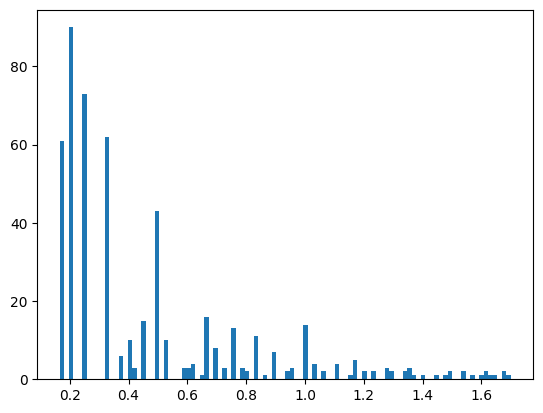

In [47]:
# Plot the histogram of edge weights
weights = np.array([v['weight'] for _, _, v in edgelist])
x = weights[~is_outlier(weights)]
plt.hist(x, bins=100)
plt.show()

In [48]:
# Create a graph
g_nodes = foods.to_dict('index')
g_nodes = [(k, v) for k, v in g_nodes.items()]

g = nx.Graph()

g.add_nodes_from(g_nodes)
g.add_edges_from(edgelist)

print(len(g.nodes))
print(len(g.edges))

145
615


In [50]:
nx.write_gexf(g, "vegetables_graph_sparse.gexf")

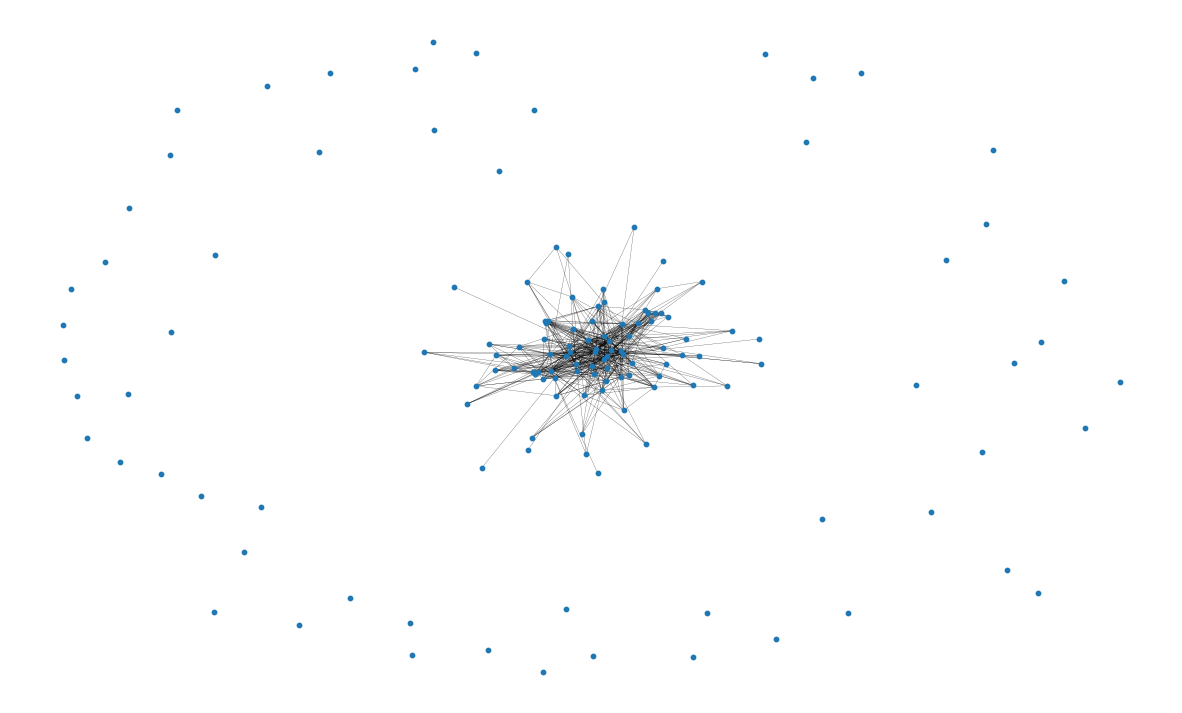

In [51]:
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(g, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(g, pos=pos, ax=ax, **plot_options)

## Post Analysis

First, I'd like to know which compounds are most enriched in which kinds of food. To do this, we can group the foods by food_type, and then look for the compounds that are found in each category of food.
However, "enriched" can be measured in different ways:
- We could look at breadth by choosing the compounds that are most often found in different foods of the food category
- We could look at depth by choosing the compounds that are most "concentrated" in the food category
- We could use a metric that captures both breadth and depth by scaling the concentration of each compound by the cohort size of the food category
- We could look for compounds that are proportionally much more "enriched" in one food category with respect to other food categories

Once we have these compounds aggregated by food category, we can then peek into the category and rank the individual foods by their individual contribution to the cohort compound metric

In [383]:
foods = pd.read_csv('data/Food.csv', header=0, index_col=0)
compounds = pd.read_csv('data/Compound.csv', header=0, index_col=0)
content = pd.read_csv('data/Content.csv', header=0, index_col=0)

/var/folders/ln/wx93hvrs02d003t516fpf0xc0000gn/T/ipykernel_70942/3428497312.py:2: DtypeWarning: Columns (3,4,5,6,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  compounds = pd.read_csv('data/Compound.csv', header=0, index_col=0)
/var/folders/ln/wx93hvrs02d003t516fpf0xc0000gn/T/ipykernel_70942/3428497312.py:3: DtypeWarning: Columns (4,5,6,7,8,9,13,14,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  content = pd.read_csv('data/Content.csv', header=0, index_col=0)


In [384]:
# Filter out compound observations that aren't related to our foods of interest
content = content[content['source_type'] == 'Compound']
content = content[content['food_id'].isin(foods.index)]

# Filter out compound observations that aren't related to our compounds of interest
content = content[content['source_id'].isin(compounds.index)]

# Filter out compounds that aren't found in our foods of interest 
relevant_compounds = content['source_id'].unique()
compounds = compounds[compounds.index.isin(relevant_compounds)]

In [385]:
print("There are %d compounds out of %d that are observed in the food list" % (len(relevant_compounds), 85593))

There are 61287 compounds out of 85593 that are observed in the food list


I noticed that there were many repeated observations of the same compound in the same food
Thus, for a single food-compound pair, I need to batch the observations and choose a statistic to summarize the batch
I decided to use the mean of the compound concentration for each batch in the column dubbed `orig_content`

However, before moving forward, I realized that the compound concentration was being measured with different units in different experiments. So, I needed to either discard some units from consideration or find a way to re-normalize the units 

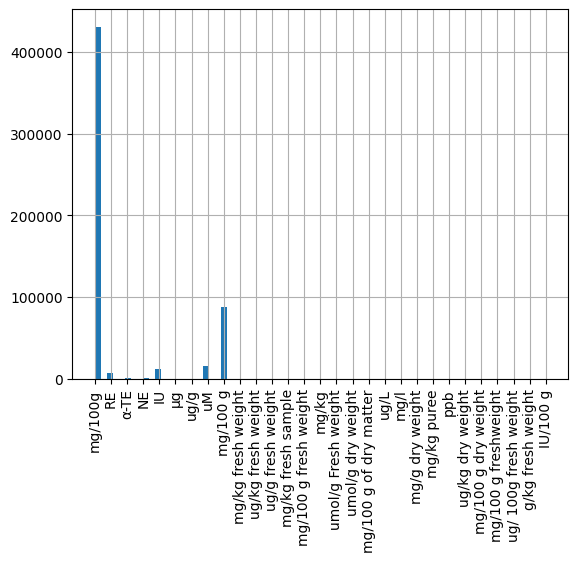

In [386]:
# Let's plot the prevalence of each unit type in a histogram
content['orig_unit'].hist(bins=75)
plt.xticks(rotation='vertical')
plt.show()

In [387]:
# It seems that `mg/100g` is used most often
# Let's see what percentage of the frame this metric covers
counts = content['orig_unit'].value_counts()
(counts['mg/100g'] + counts['mg/100 g']) / content['orig_unit'].count()

0.9320278112143152

In [388]:
# I think for this first run, I'm just gonna keep the rows that use the `mg/100g`
# We can consider converting other units to this metric in the future
content = content[content['orig_unit'].isin(['mg/100g', 'mg/100 g'])]
content.dropna(subset=['orig_content'], inplace=True)

## Analyzing the enrichment of compounds by food category

In [158]:
# Now I want to group the foods by category and extract the compound observations that are relevant to each food_group
food_ids_grouped = foods.groupby('food_group').apply(lambda r: r.index)
food_groups = food_ids_grouped.index

for idx, fids in enumerate(food_ids_grouped):
    obs = content[content['food_id'].isin(fids)]
    unique_compounds = obs['source_id'].unique()
    unique_obs = obs.groupby(['food_id', 'source_id'])['orig_content'].mean()
    print('%s category has %d/%d unique compound observations and %d unique compounds' % \
        (food_groups[idx], len(unique_obs), len(obs), len(unique_compounds)))

Animal foods category has 1068/94934 unique compound observations and 107 unique compounds
Aquatic foods category has 9749/32890 unique compound observations and 117 unique compounds
Baby foods category has 106/14637 unique compound observations and 106 unique compounds
Baking goods category has 2340/17779 unique compound observations and 138 unique compounds
Beverages category has 2525/15752 unique compound observations and 519 unique compounds
Cereals and cereal products category has 3690/56878 unique compound observations and 320 unique compounds
Cocoa and cocoa products category has 493/3371 unique compound observations and 155 unique compounds
Coffee and coffee products category has 464/4903 unique compound observations and 145 unique compounds
Confectioneries category has 2139/26763 unique compound observations and 120 unique compounds
Dishes category has 3200/42998 unique compound observations and 118 unique compounds
Eggs category has 106/3563 unique compound observations and 1

In [251]:
def replace_index_by_value(index, ref_df, colname):
    return [ref_df.loc[idx, colname] for idx in index]

def replace_index_for_tuple(index_tuple):
    a_tup = replace_index_by_value([t[0] for t in index_tuple], foods, 'name')
    b_tup = replace_index_by_value([t[1] for t in index_tuple], compounds, 'name')
    return list(zip(a_tup, b_tup))

def pretty_print_df_head(idx, df):
    df.index = replace_index_for_tuple(df.index)
    print('Category ', food_groups[idx])
    print(df.head())
    print()

In [289]:
## So, it seems that redundant compound observations in the same foods are quite prevalent
#  I will take some time later to quantify the variance on some of these redundant operations, 
#  but for now let's just take the mean.

for idx, fids in enumerate(food_ids_grouped):
    obs = content[content['food_id'].isin(fids)]
    
    # This gives us the mean concentration for each (food, compound) pair
    mean_obs_by_food = obs.groupby(['food_id', 'source_id'])['orig_content'].mean()
    mean_obs_by_food = mean_obs_by_food.sort_values(ascending=False)
    
    # Now, let's find the foods that have the highest concentration for each compound in the food family
    mask = mean_obs_by_food.groupby('source_id').transform(lambda x: x==x.max()).astype(bool)
    obs_by_compound = mean_obs_by_food[mask]
    
    # Now for each food category, let's find the food that contains the most variety of compounds
    # We can start viewing these as superfoods since they pack the highest diversity of compounds in one
    # However, we could be getting research bias here if some foods are studied more often than others
    compounds_per_food = mean_obs_by_food.groupby('food_id').count().sort_values(ascending=False)
    compounds_per_food.index = replace_index_by_value(compounds_per_food.index, foods, 'name')

Finally for this food centric analysis, I'd like to find compounds that are particularly enriched in one family of foods in comparison to other food families. To do this, I will take the sum of compound concentrations divided by the number of foods in a given food category. Here is the formula for each compound $c$ and food $f$

$$
S_{F,c} = \frac{1}{|F|} \sum_{f}[c]_f
$$

where $S_{F,c}$ is the local enrichment score for a given compound $c$ in a food family $F$, $|F|$ is the number of foods in a food family, and $[c]_f$ is the concentration of compound $c$ in food $f$.

Then, to compute the relative food enrichment score across food families, I will compute the following relative score for each compound $c$ in each food family $F$

$$
S^r_{F,c} = \frac{S_{F,c}}{\sum_F S_{F,c}}
$$

In [325]:
raw_compound_count = pd.Series(0.0, index=compounds.index)

for fids in tqdm(food_ids_grouped):
    F = len(fids)
    obs = content[content['food_id'].isin(fids)]    
    mean_obs_by_food = obs.groupby(['food_id', 'source_id'])['orig_content'].mean()
    
    # Add the raw enrichment sum to the raw compound count series
    raw_enrichment_scores = mean_obs_by_food.groupby('source_id').apply(lambda x: x.sum()/F)
    raw_compound_count = raw_compound_count.add(raw_enrichment_scores, fill_value=0.0)

100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 31.76it/s]


In [327]:
raw_compound_count = raw_compound_count[raw_compound_count>0]

In [ ]:
def process_enrichment(x, F):
    s = x.sum()/F
    if s == 0:
        return 0.0
    else:
        norm = raw_compound_count[x.index[0][1]]
        return s/norm

for idx, fids in enumerate(food_ids_grouped):
    F = len(fids)
    obs = content[content['food_id'].isin(fids)]
    mean_obs_by_food = obs.groupby(['food_id', 'source_id'])['orig_content'].mean()
    
    enrichment_scores = mean_obs_by_food \
        .groupby('source_id') \
        .apply(lambda x: process_enrichment(x, F)) \
        .sort_values(ascending=False)
            
    enrichment_scores = enrichment_scores[enrichment_scores>0]
    
    enrichment_scores.index = replace_index_by_value(enrichment_scores.index, compounds, 'name')
    enrichment_scores = enrichment_scores[enrichment_scores > 0]
    
    print('Category ', food_groups[idx])
    print(enrichment_scores.head(10))
    print()

## Analyzing the compound enrichment at the basic food item level

Finally, now that we have some interesting compounds that are relatively enriched in some food families, I'd like to take the same food-centric graph that I built previously, and add some node weights to highlight the relative food enrichment metric that we just computed. To accomplish this, we will need to compute this same normalized enrichment score, but at the food level instead of the food group level

In [466]:
# First let's choose a set of compounds that we'd like to analyze in graph format
# I'm going to choose some compounds that I find interesting as well as some that our previous analysis cooked up
targets = [
    'Retinol',
    'Nitrate', 'Nitrogen',
    'Sodium',
    'Sucrose', 'D-Glucose', 'Sugars', 'Lactose', 'Maltose',
    'Cholesterol'
]

In [ ]:
# I use this fuzzy matching tool to find targets with relatively high abundance in the observations
matches = difflib.get_close_matches('Cholesterol', compounds['name'], n=10)
ids = compounds[compounds['name'].isin(matches)].index

t = content[content['source_id'].isin(ids)].groupby('source_id').size().to_frame()
t['name'] = compounds.loc[t.index]['name']
t

In [480]:
# Now that we have a set of targets, we can go ahead and compute their enrichment scores in each food item
# First we compute a total enrichment score by adding up all the individual concentrations across all foods
target_ids = compounds[compounds['name'].isin(targets)].index

# Some foods might have many observations, so we again take the mean score for such foods
mean_obs_by_food = content[content['source_id'].isin(target_ids)] \
                    .groupby(['food_id', 'source_id'])['orig_content'].mean()

total_enrichment = mean_obs_by_food.groupby('source_id').sum().to_frame()
total_enrichment['name'] = compounds.loc[total_enrichment.index]['name']

In [489]:
# Now we do the same enrichment calculation, but at the per food level
# This will give us normalized enrichment scores for each food
mean_obs_by_food = mean_obs_by_food[mean_obs_by_food > 0].to_frame()

In [498]:
local_enrichment = mean_obs_by_food.reset_index()

In [503]:
food_groups = [foods.loc[idx, 'food_group'] for idx in local_enrichment['food_id']]
local_enrichment['food_group'] = food_groups

In [508]:
local_enrichment

,food_id,source_id,orig_content,food_group
0,2,3524,28.000000,Vegetables
1,2,13401,300.000000,Vegetables
2,2,13831,0.016667,Vegetables
3,4,1131,1068.571429,Fruits
4,4,1193,80.000000,Fruits
...,...,...,...,...
3006,1021,13401,1550.000000,Teas
3007,1022,13272,327827.500000,NaN
3008,1023,3524,202.000000,NaN
3009,1023,3716,1230.000000,NaN


In [514]:
local_enrichment['scaled_content'] = \
    local_enrichment.apply(lambda r: r['orig_content'] / total_enrichment.loc[r['source_id'], 'orig_content'], axis=1)

In [531]:
local_enrichment['name'] = \
    local_enrichment.apply(lambda r: compounds.loc[r['source_id'], 'name'], axis=1)

In [564]:
nodes = foods

for target in targets:
    enrichments = local_enrichment[local_enrichment['name'] == target][['food_id', 'orig_content']].set_index('food_id')
    enrichments.rename(columns={'orig_content': target+'_enrichment'}, inplace=True)
    nodes = nodes.merge(enrichments, left_index=True, right_index=True, how="outer")

In [567]:
edgelist = []
nodex = nodes.index

for i in tqdm(range(len(nodex))):
    for j in range(i+1, len(nodex)):
        food1 = nodex[i]
        food2 = nodex[j]
        
        if nodes.loc[food1, 'food_group'] == nodes.loc[food2, 'food_group']:
            edgelist.append((food1, food2))    

100%|████████████████████████████████████████| 992/992 [00:08<00:00, 120.18it/s]


In [570]:
g_nodes = nodes.to_dict('index')
g_nodes = [(k, v) for k, v in g_nodes.items()]

g = nx.Graph()

g.add_nodes_from(g_nodes)
g.add_edges_from(edgelist)

print(len(g.nodes))
print(len(g.edges))

992
51399


In [ ]:
nx.write_gexf(g, "full_graph_with_ctargets.gexf")